<a href="https://colab.research.google.com/github/extrajp2014/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module2-survival-analysis/LS_DS2_232_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Survival Analysis
![My normal approach is useless here, too.](https://imgs.xkcd.com/comics/probability.png)

https://xkcd.com/881/

The aim of survival analysis is to analyze the effect of different risk factors and use them to predict the duration of time between one event ("birth") and another ("death").

# Lecture

Survival analysis was first developed by actuaries and medical professionals to predict (as its name implies) how long individuals would survive. However, it has expanded into include many different applications.
* it is referred to as **reliability analysis** in engineering
* it can be referred to more generally as **time-to-event analysis**

In the general sense, it can be thought of as a way to model anything with a finite duration - retention, churn, completion, etc. The culmination of this duration may have a "good" or "bad" (or "neutral") connotation, depending on the situation. However old habits die hard, so most often it is called survival analysis and the following definitions are still commonly used:

* birth: the event that marks the beginning of the time period for observation
* death: the event of interest, which then marks the end of the observation period for an individual

### Examples
* Customer churn
 * birth event: customer subscribes to a service
 * death event: customer leaves the service
* Employee retention
 * birth event: employee is hired
 * death event: employee quits
* Engineering, part reliability
 * birth event: part is put in use
 * death event: part fails
* Program completion
 * birth event: student begins PhD program
 * death event: student earns PhD
* Response time
 * birth event: 911 call is made
 * death event: police arrive
* Lambda School
 * birth event: student graduates LambdaSchool
 * death event: student gets a job!
 
Take a moment and try to come up with your own specific example or two.

#### So... if all we're predicting here is a length of time between two events, why can't we just use regular old Linear Regression?
Well... if you have all the data, go for it. In some situations it may be reasonably effective.

#### But, data for survival times are often highly skewed and, more importantly, we don't always get a chance to observe the "death" event. The current time or other factors interfere with our ability to observe the time of the event of interest. These observations are said to be _censored_.

Additionally, the occurrence or non-occurrence of an event is binary - so, while the time is continuous, the event itself is in some ways similar to a binary event in logistic regression.

## Censorship in Data

Suppose a new cancer treatment is developed. Researchers select 50 individuals for the study to undergo treatment and participate in post-treatment obsesrvation.

##### Birth Event = Participant begins trial
##### Death Event = Participant dies due to cancer or complications of cancer
During the study:
1. Some participants die during the course of the study--triggering their death event 
2. Some participants drop out or the researchers otherwise lose contact with them. The researchers have their data up intil the time they dropped out, but they don't have a death event to record
3. Some participants are still be alive at the end of the observation period. So again, researchers have their data up until some point, but there is no death event to record

We only know the interval between the "birth" event and the "death" event for participants in category 1. All others we only know that they survived _up to_ a certain point.

### Dealing with Censored Data

Without survival analysis, we could deal with censored data in two ways:
* We could just treat the end of the observation period as the time of the death event
* (Even worse) We could drop the censored data using the rationale that we have "incomplete data" for those observations

But... both of these will underestimate survival rates for the purpose of the study. We **know** that all those individuals "survived" the "death event" past a certain point.

Luckily, in the 1980s a pair of smarty pants named David (main author Cox and coauthor Oakes) did the hard math work to make it possible to incorporate additional features as predictive measures to survival time probabilities. (Fun fact, the one named Cox also came up with logistic regression with non-David coauthor, Joyce Snell.)

## lifelines
It wasn't until 2014 that some other smart people made an implementation of survival analysis in Python called lifelines. 
It is built over Pandas and follows the same conventions for usage as scikit-learn.

_Additional note: scikit pushed out a survival analysis implementation last year (2018) named scikit-survival that is imported by the name `sksurv`. It's super new so it may/may not have a bunch of bugs... but if you're interested you can check it out in the future. (For comparison, scikit originally came out in 2007 and Pandas came out in 2008)._

In [34]:
!pip install lifelines

    100% |████████████████████████████████| 266kB 7.5MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

In [0]:
# lifelines comes with some datasets to get you started playing around with it.
# Most of the datasets are cleaned-up versions of real datasets. Here we will
# use their Leukemia dataset comparing 2 different treatments taken from
# http://web1.sph.emory.edu/dkleinb/allDatasets/surv2datasets/anderson.dat

from lifelines.datasets import load_leukemia
leukemia = load_leukemia()
print(leukemia.shape)
leukemia.head()

(42, 5)


,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


In [0]:
?load_leukemia

### You can use any Pandas DataFrame with lifelines. 
### The only requirement is that the DataFrame includes features that describe:
* a duration of time for the observation
* a binary column regarding censorship (`1` if the death event was observed, `0` if the death event was not observed)

Sometimes, you will have to engineer these features. How might you go about that? What information would you need?

In [0]:
leukemia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
t         42 non-null int64
status    42 non-null int64
sex       42 non-null int64
logWBC    42 non-null float64
Rx        42 non-null int64
dtypes: float64(1), int64(4)
memory usage: 1.7 KB


In [0]:
leukemia.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


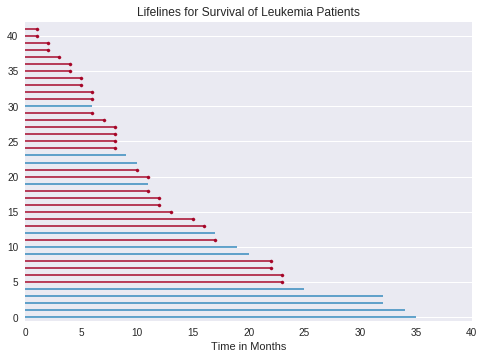

In [0]:
time = leukemia.t.values
event = leukemia.status.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Leukemia Patients");
plt.plot();

## Kaplan-Meier survival estimate
 
The Kaplan-Meier method estimates survival probability from observed survival times. It results in a step function that changes value only at the time of each event, and confidence intervals can be computed for the survival probabilities. 

The KM survival curve,a plot of KM survival probability against time, provides a useful summary of the data.
It can be used to estimate measures such as median survival time.

It CANNOT account for risk factors and is NOT regression. It is *non-parametric* (does not involve parameters).

However it is a good way to visualize a survival dataset, and can be useful to compare the effects of a single categorical variable.

In [0]:
kmf = lifelines.KaplanMeierFitter()

kmf.fit(time, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 42 observations, 12 censored>

In [0]:
# !pip install -U matplotlib  # Colab has matplotlib 2.2.3, we need >3

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.2)


Median Survival: 12.0 months after treatment


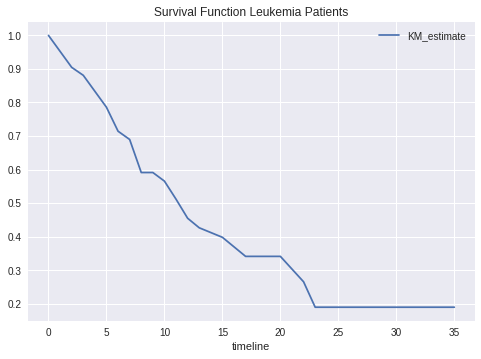

In [0]:
kmf.survival_function_.plot()
plt.title('Survival Function Leukemia Patients');
print(f'Median Survival: {kmf.median_} months after treatment')

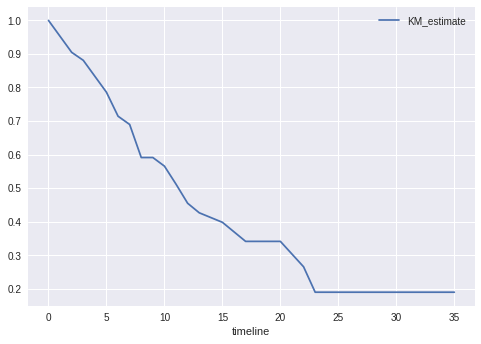

In [0]:
kmf.survival_function_.plot.line()

Median survival time with Treatment 1: 8.0 months
Median survival time with Treatment 0: 23.0 months


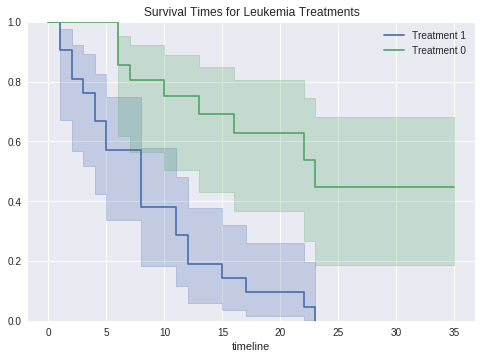

In [0]:
ax = plt.subplot(111)

treatment = (leukemia["Rx"] == 1)
kmf.fit(time[treatment], event_observed=event[treatment], label="Treatment 1")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 1: {kmf.median_} months')

kmf.fit(time[~treatment], event_observed=event[~treatment], label="Treatment 0")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 0: {kmf.median_} months')

plt.ylim(0, 1);
plt.title("Survival Times for Leukemia Treatments");

## Cox Proportional Hazards Model -- Survival Regression
It assumes the ratio of death event risks (hazard) of two groups remains about the same over time.
This ratio is called the hazards ratio or the relative risk.

All Cox regression requires is an assumption that ratio of hazards is constant over time across groups.
The good news—we don’t need to know anything about overall shape of risk/hazard over time
The bad news—the proportionality assumption can be restrictive

In [0]:
# Using Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(leukemia, 't', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 42 observations, 12 censored>
      duration col = 't'
         event col = 'status'
number of subjects = 42
  number of events = 30
    log-likelihood = -69.59
  time fit was run = 2019-02-26 18:34:24 UTC

---
        coef  exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
sex     0.31       1.37      0.45 0.69   0.49      1.03       -0.58        1.21
logWBC  1.68       5.38      0.34 5.00 <0.005     20.71        1.02        2.34
Rx      1.50       4.50      0.46 3.26 <0.005      9.80        0.60        2.41
---
Concordance = 0.85
Log-likelihood ratio test = 47.19 on 3 df, -log2(p)=31.55


/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


## Interpreting the Results
`coef`: usually denoted with $b$, the coefficient

`exp(coef)`: $e^{b}$, equals the estimate of the hazard ratio. Here, we can say that participants who received treatment 1 had ~4.5 times the hazard risk (risk of death) compared to those who received treatment 2. And for every unit the `logWBC` increased, the hazard risk increased >5 times.

`se(coef)`: standard error of the coefficient (used for calculating z-score and therefore p-value)

`z`: z-score $\frac{b}{se(b)}$

`p`: p-value. derived from z-score. describes statistical significance. more specifically, it is the likelihood that the variable has no effect on the outcome

`log(p)`: natural logarithm of p-value... used to more easily see differences in significance

`lower/upper 0.95`: confidence levels for the coefficients. in this case, we can confidently say that the coefficient for `logWBC` is somewhere _between_ 1.02 and 2.34.

`Signif. codes`: easily, visually identify significant variables! The more stars, the more solid (simply based on p-value). Here `logWBC` is highly significant, `Rx` is significant, and `sex` has no statistical significance

`Concordance`: a measure of predictive power for classification problems (here looking at the `status` column. a value from 0 to 1 where values above 0.6 are considered good fits (the higher the better)

`Likelihood ratio (LR) test`: this is a measure of how likely it is that the coefficients are not zero, and can compare the goodness of fit of a model versus an alternative null model. Is often actually calculated as a logarithm, resulting in the log-likelihood ratio statistic and allowing the distribution of the test statistic to be approximated with [Wilks' theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem).

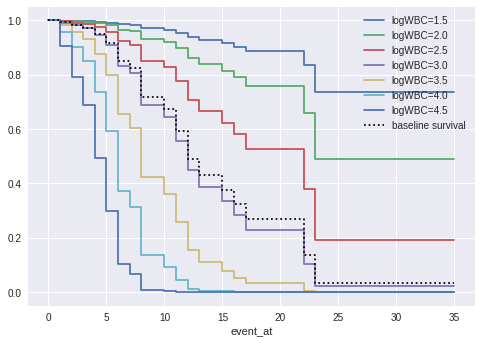

In [0]:
cph.plot_covariate_groups(covariate='logWBC', values=np.arange(1.5,5,.5))

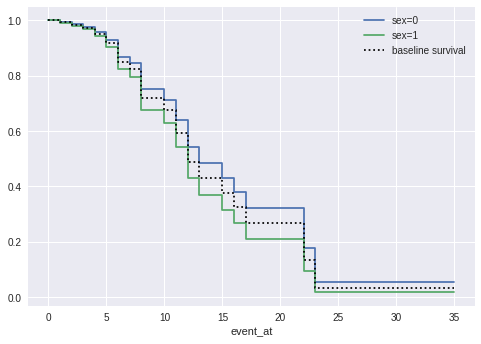

In [0]:
cph.plot_covariate_groups(covariate='sex', values=[0,1])

### Remember how the Cox model assumes the ratio of death events between groups remains constant over time?
Well we can check for that.

In [0]:
cph.check_assumptions(leukemia)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
             test_statistic    p  -log2(p)
Rx     km              0.23 0.63      0.67
       rank            0.44 0.51      0.98
logWBC km              0.10 0.76      0.40
       rank            0.16 0.68      0.55
sex    km              3.78 0.05      4.27
       rank            4.91 0.03      5.23


1. Variable 'sex' failed the non-proportional test: p-value is 0.0267.
   Advice: with so few 

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


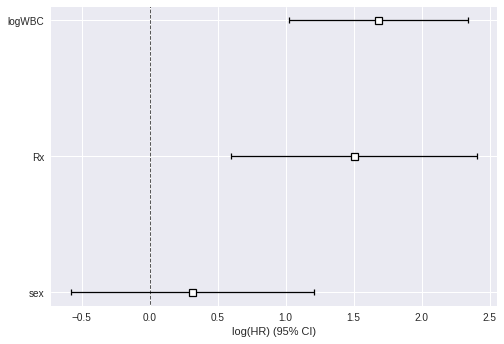

In [0]:
# We can see that the sex variable is not very useful by plotting the coefficients
cph.plot()

In [0]:
# Let's do what the check_assumptions function suggested
cph = lifelines.CoxPHFitter()
cph.fit(leukemia, 't', event_col='status', strata=['sex'])
cph.print_summary()
cph.baseline_cumulative_hazard_.shape

<lifelines.CoxPHFitter: fitted with 42 observations, 12 censored>
      duration col = 't'
         event col = 'status'
            strata = ['sex']
number of subjects = 42
  number of events = 30
    log-likelihood = -55.73
  time fit was run = 2019-02-26 18:54:43 UTC

---
        coef  exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
logWBC  1.45       4.28      0.34 4.22 <0.005     15.35        0.78        2.13
Rx      1.00       2.71      0.47 2.11   0.04      4.83        0.07        1.93
---
Concordance = 0.81
Log-likelihood ratio test = 69.61 on 2 df, -log2(p)=50.21


/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


(24, 2)

Notice that this regression has `Likelihood ratio test = 74.90 on 2 df, log(p)=-37.45`, while the one that included `sex` had `Likelihood ratio test = 47.19 on 3 df, log(p)=-21.87`. The LRT is higher and log(p) is lower, meaning this is likely a better fitting model.

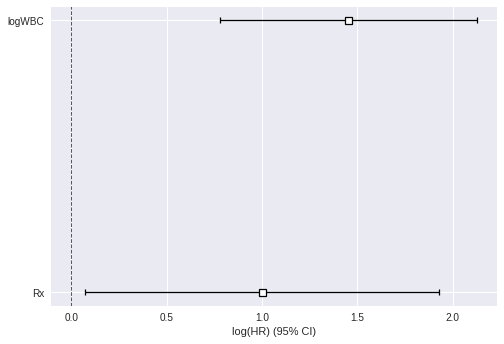

In [0]:
cph.plot()

In [0]:
cph.compute_residuals(leukemia, kind='score')

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column Rx have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['status'].astype(bool)
>>> df.loc[events, 'Rx'].var()
>>> df.loc[~events, 'Rx'].var()

Too low variance here means that the column Rx completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


,sex,logWBC,Rx
41,0.151438,0.493154,0.093001
40,0.257418,-1.320832,0.158085
39,0.168547,0.212059,0.103508
38,0.022468,0.009969,0.013798
37,0.330207,0.294987,0.202786
36,0.500469,-1.199854,0.307347
35,0.065397,0.133997,0.040162
34,0.044322,0.362879,0.228334
33,0.397637,0.181262,0.337132
19,0.352553,0.397060,-0.050102


In [0]:
cph.predict_cumulative_hazard(leukemia[:5])

,0,1,2,3,4
1.0,0.001231,0.001268,0.003663,0.005919,0.001989
2.0,0.002998,0.003086,0.008919,0.014410,0.004844
3.0,0.005017,0.005165,0.014925,0.024114,0.008105
4.0,0.010236,0.010538,0.030452,0.049199,0.016537
5.0,0.015623,0.016084,0.046479,0.075091,0.025241
6.0,0.023143,0.023826,0.068850,0.111234,0.037390
7.0,0.023143,0.023826,0.068850,0.111234,0.037390
8.0,0.034436,0.035452,0.102447,0.165514,0.055635
9.0,0.034436,0.035452,0.102447,0.165514,0.055635
10.0,0.034436,0.035452,0.102447,0.165514,0.055635


,0
0,31.141527
1,31.063377
2,26.570826
3,23.308517
4,29.577589


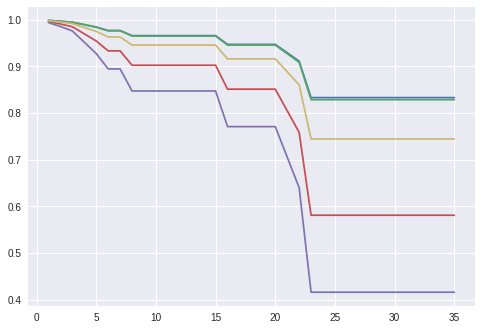

In [0]:
surv_func = cph.predict_survival_function(leukemia[:5])

exp_lifetime = cph.predict_expectation(leukemia[:5])

plt.plot(surv_func)

exp_lifetime

In [0]:
# lifelines comes with some datasets to get you started playing around with it
# The Rossi dataset originally comes from Rossi et al. (1980), 
# and is used as an example in Allison (1995). 

# The data pertain to 432 convicts who were released from Maryland state prisons 
# in the 1970s and who were followed up for one year after release. Half the 
# released convicts were assigned at random to an experimental treatment in 
# which they were given financial aid; half did not receive aid.

from lifelines.datasets import load_rossi
recidivism = load_rossi()

recidivism.head()

# Looking at the Rossi dataset, how long do you think the study lasted?

# All features are coded with numerical values, but which features do you think 
# are actually categorical?

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [0]:
recidivism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
week      432 non-null int64
arrest    432 non-null int64
fin       432 non-null int64
age       432 non-null int64
race      432 non-null int64
wexp      432 non-null int64
mar       432 non-null int64
paro      432 non-null int64
prio      432 non-null int64
dtypes: int64(9)
memory usage: 30.5 KB


In [0]:
recidivism.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


### These are the "lifelines" of the study participants as they attempt to avoid recidivism

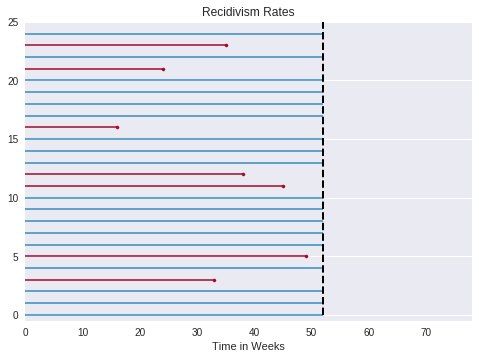

In [0]:
recidivism_sample = recidivism.sample(n=25)

duration = recidivism_sample.week.values
arrested = recidivism_sample.arrest.values

ax = lifelines.plotting.plot_lifetimes(duration, event_observed=arrested)
ax.set_xlim(0, 78)
ax.grid(axis='x')
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.set_xlabel("Time in Weeks")
ax.set_title("Recidivism Rates");
plt.plot();

In [0]:
kmf = lifelines.KaplanMeierFitter()

duration = recidivism.week
arrested = recidivism.arrest

kmf.fit(duration, arrested)

0    0.5
dtype: float64


<lifelines.KaplanMeierFitter: fitted with 432 observations, 318 censored>

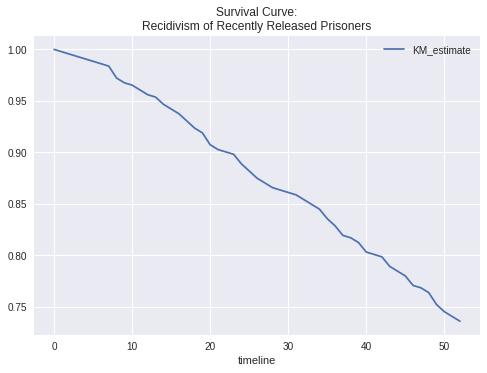

In [0]:
kmf.survival_function_.plot()
plt.title('Survival Curve:\nRecidivism of Recently Released Prisoners');

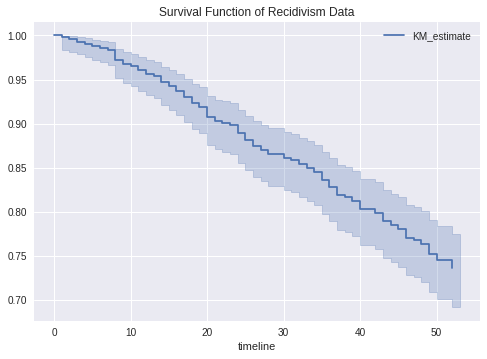

In [0]:
kmf.plot()
plt.title('Survival Function of Recidivism Data');

In [0]:
print(f'Median time before recidivism: {kmf.median_} weeks')

Median time before recidivism: inf weeks


0    0.5
dtype: float64
0    0.5
dtype: float64


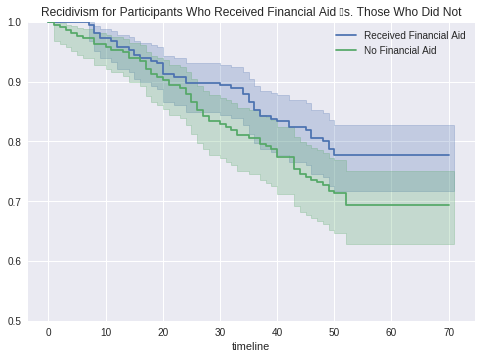

In [0]:
kmf_w_aid = lifelines.KaplanMeierFitter()
kmf_no_aid = lifelines.KaplanMeierFitter()

ax = plt.subplot(111)

w_aid = (recidivism['fin']==1)

t = np.linspace(0, 70, 71)
kmf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid], timeline=t, label="Received Financial Aid")
ax = kmf_w_aid.plot(ax=ax)
#print("Median survival time of democratic:", kmf.median_)

kmf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid], timeline=t, label="No Financial Aid")
ax = kmf_no_aid.plot(ax=ax)
#print("Median survival time of non-democratic:", kmf.median_)

plt.ylim(.5,1)
plt.title("Recidivism for Participants Who Received Financial Aid \vs. Those Who Did Not");

          NA_estimate
timeline             
0.0          0.000000
1.0          0.002315
2.0          0.004635
3.0          0.006961
4.0          0.009292


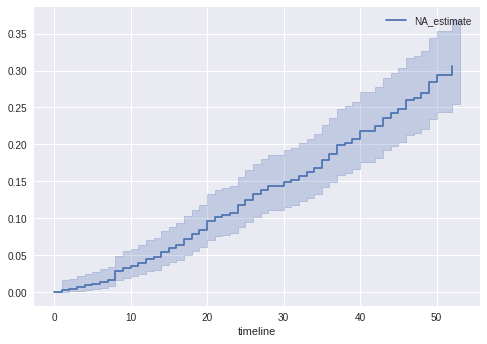

In [0]:
naf = lifelines.NelsonAalenFitter()
naf.fit(duration, arrested)

print(naf.cumulative_hazard_.head())
naf.plot()

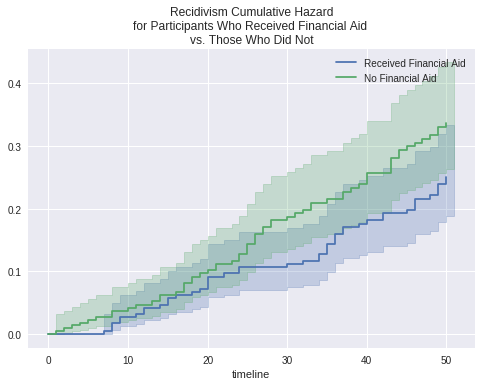

In [0]:
naf_w_aid = lifelines.NelsonAalenFitter()
naf_no_aid = lifelines.NelsonAalenFitter()

naf_w_aid.fit(duration[w_aid], event_observed=arrested[w_aid], timeline=t, label="Received Financial Aid")
ax = naf_w_aid.plot(loc=slice(0, 50))
naf_no_aid.fit(duration[~w_aid], event_observed=arrested[~w_aid], timeline=t, label="No Financial Aid")
ax = naf_no_aid.plot(ax=ax, loc=slice(0, 50))
plt.title("Recidivism Cumulative Hazard\nfor Participants Who Received Financial Aid \nvs. Those Who Did Not");
plt.show()

In [0]:
cph = lifelines.CoxPHFitter()
cph.fit(recidivism, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48337, step_size = 0.95000, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.95000, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.95000, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00103, step_size = 0.95000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00005, step_size = 0.95000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-01-22 18:30:09 UTC

---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  u

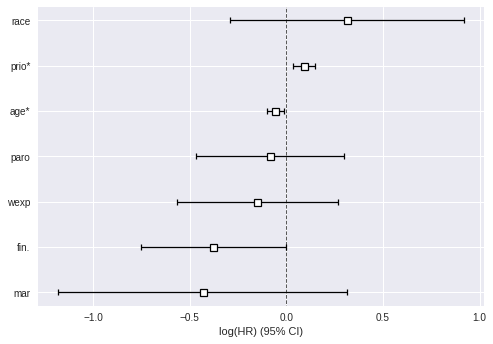

In [0]:
cph.plot()

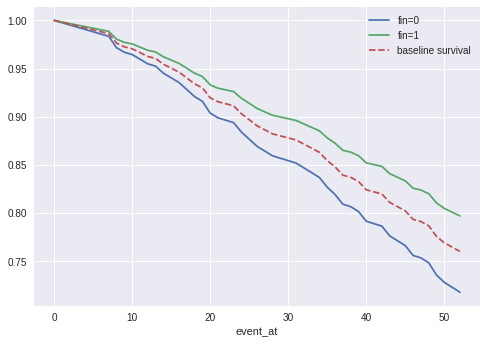

In [0]:
cph.plot_covariate_groups('fin', [0, 1])

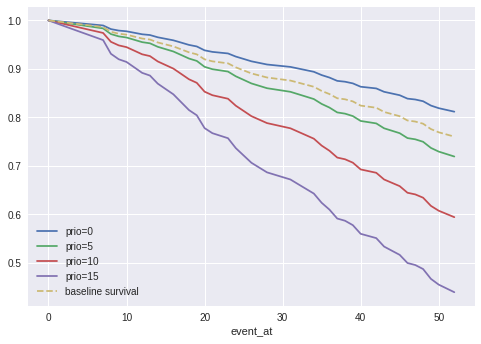

In [0]:
cph.plot_covariate_groups('prio', [0, 5, 10, 15])

In [0]:
r = cph.compute_residuals(recidivism, 'martingale')
r.head()

,arrest,martingale,week
313,True,0.997048,1.0
100,True,0.998585,2.0
183,True,0.993959,3.0
416,True,0.987465,4.0
79,True,0.979341,5.0


In [0]:
cph = lifelines.CoxPHFitter()
cph.fit(recidivism, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48337, step_size = 0.95000, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.95000, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.95000, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00103, step_size = 0.95000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00005, step_size = 0.95000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-01-22 18:30:10 UTC

---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  u

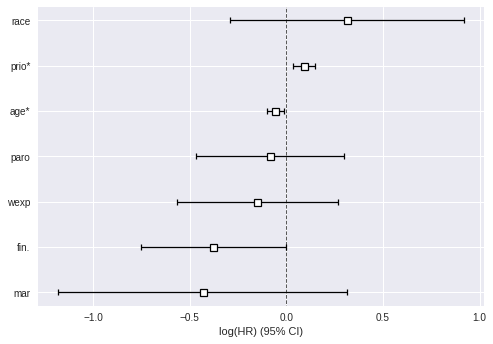

In [0]:
cph.plot();

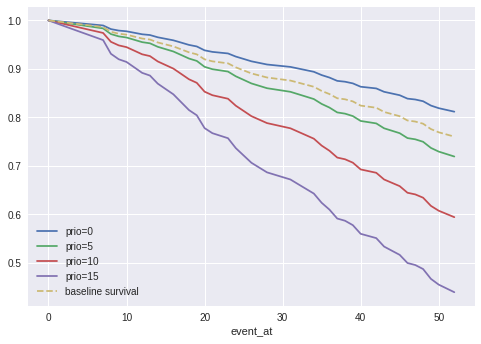

In [0]:
cph.plot_covariate_groups('prio', [0, 5, 10, 15]);

0    0.5
dtype: float64

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
               test_statistic      p  log(p)    
age  identity           12.06 <0.005   -7.57  **
     km                 11.03 <0.005   -7.02  **
     log                13.07 <0.005   -8.11  **
     rank               11.09 <0.005   -7.05  **
fin  identity            0.06   0.81   -0.21    
     km                  0.02   0.89   -0.12    
     log                 0.49   0.48   -0.73    
     rank                0.02   0.90   -0.11    
mar  identity            0.75   0.39   -0.95    
     km                  0.60   0.44   -0.82    
     log                 1.03   0.31   -1.17    
     rank                0.67   0.41   -0.88    
paro identity            0.12   0.73   -0.32    
     km                  0.12   0.73   -0.31    
     log                 0.01   0.92   -0.09    
     rank                0.14   0.71   -0.34    
prio 

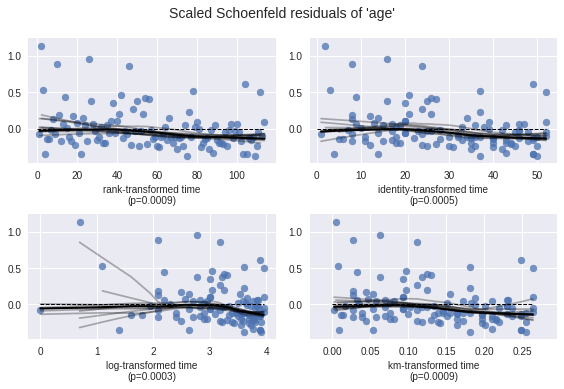

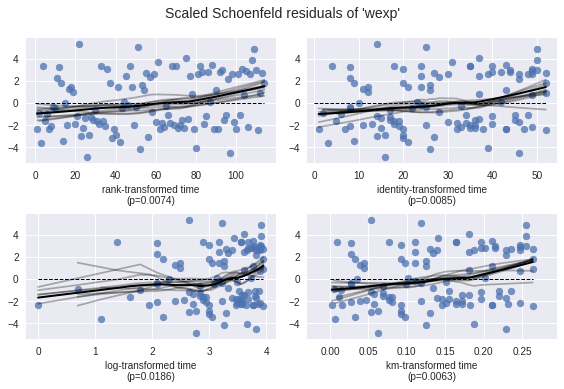

In [0]:
cph.check_assumptions(recidivism)

## The Intuition - Hazard and Survival Functions

### Hazard Function - the dangerous bathtub

The hazard function represents the *instantaneous* likelihood of failure. It can be treated as a PDF (probability density function), and with real-world data comes in three typical shapes.

![Different hazard functions](https://upload.wikimedia.org/wikipedia/commons/2/25/Compsyseng17_04.jpg)

Increasing and decreasing failure rate are fairly intuitive - the "bathtub" shaped is perhaps the most surprising, but actually models many real-world situations. In fact, life expectancy in general, and most threats to it, assume this shape.

What the "bathtub" means is that - threats are highest at youth (e.g. infant mortality), but then decrease and stabilize at maturity, only to eventually re-emerge in old age. Many diseases primarily threaten children and elderly, and middle aged people are also more robust to physical trauma.

The "bathtub" is also suitable for many non-human situations - often with reliability analysis, mechanical parts either fail early (due to manufacturing defects), or they survive and have a relatively long lifetime to eventually fail out of age and use.

### Survival Function (aka reliability function) - it's just a (backwards) CDF

Since the hazard function can be treated as a probability density function, it makes sense to think about the corresponding cumulative distribution function (CDF). But because we're modeling time to failure, it's actually more interesting to look at the CDF backwards - this is called the complementary cumulative distribution function.

In survival analysis there's a special name for it - the survival function - and it gives the probability that the object being studied will survive beyond a given time.

![4 survival functions](https://upload.wikimedia.org/wikipedia/commons/e/e0/Four_survival_functions.svg)

As you can see they all start at 1 for time 0 - at the beginning, all things are alive. Then they all move down over time to eventually approach and converge to 0. The different shapes reflect the average/expected retention of a population subject to this function over time, and as such this is a particularly useful visualization when modeling overall retention/churn situations.

### Ways to estimate/model survival analysis - terms to be aware of
Key Components Necessary for these models - duration, and whether observation is censored.

- Kaplan Meier Estimator
- Nelson-Aalen Estimator
- Proportional Hazards (Cox Model, integrates covariates)
- Additive Hazards Model (Aalen's Additive Model, when covariates are time-dependent)

As with most statistics, these are all refinements of the general principles, with the math to back them up. Software packages will tend to select reasonable defaults, and allow you to use parameters to tune or select things. The math for these gets varied and deep - but feel free to [dive in](https://en.wikipedia.org/wiki/Survival_analysis) if you're curious!

## Live! Let's try modeling heart attack survival

https://archive.ics.uci.edu/ml/datasets/echocardiogram

In [0]:
# TODO - Live! (As time permits)
import pandas as pd

col_names = ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion',
           'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score', 'wall-motion-index',
           'mult', 'name', 'group', 'alive-at-1']

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/'
    'echocardiogram/echocardiogram.data', error_bad_lines=False, header=None,
    names=col_names)
df.head()

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [0]:
df.dtypes

survival                 object
still-alive              object
age-at-heart-attack      object
pericardial-effusion      int64
fractional-shortening    object
epss                     object
lvdd                     object
wall-motion-score        object
wall-motion-index        object
mult                     object
name                     object
group                    object
alive-at-1               object
dtype: object

In [0]:
df.isna().sum()

survival                 1
still-alive              0
age-at-heart-attack      0
pericardial-effusion     0
fractional-shortening    0
epss                     0
lvdd                     0
wall-motion-score        0
wall-motion-index        0
mult                     0
name                     0
group                    0
alive-at-1               0
dtype: int64

In [0]:
df.survival.value_counts()

1       6
0.5     6
33      5
26      5
0.75    5
12      4
27      4
25      4
36      4
22      4
19      4
29      4
41      3
34      3
31      3
24      3
16      3
10      3
32      3
5       2
20      2
28      2
2       2
53      2
.25     2
15      2
52      2
40      2
21      2
38      2
0.25    2
49      2
13      2
17      2
35      2
37      2
46      1
45      1
23      1
50      1
11      1
?       1
44      1
19.5    1
57      1
7.5     1
4       1
3       1
03      1
47      1
48      1
7       1
.75     1
1.25    1
55      1
9       1
.03     1
Name: survival, dtype: int64

In [0]:
import numpy as np

df = df.replace('?', np.nan)
df.isna().sum()

survival                  2
still-alive               1
age-at-heart-attack       6
pericardial-effusion      0
fractional-shortening     8
epss                     15
lvdd                     11
wall-motion-score         4
wall-motion-index         2
mult                      3
name                      1
group                    22
alive-at-1               57
dtype: int64

In [0]:
df.survival = pd.to_numeric(df.survival)
df['still-alive'] = pd.to_numeric(df['still-alive'])

/usr/local/lib/python3.6/dist-packages/lifelines/plotting.py:214: UserWarning: For less visual clutter, you may want to subsample to less than 80 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 80 individuals.")


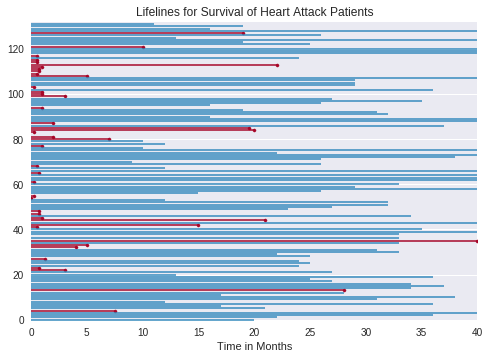

In [0]:
time = df.survival.values
event = df['still-alive'].values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Heart Attack Patients");
plt.plot();

# Assignment - Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

Your assignment is to [use their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answer the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

Good luck!

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
sns.__version__
import lifelines

In [22]:
# Loading the data to get you started
df = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [0]:
df.info()  # A lot of these are "object" - some may need to be fixed...

In [0]:
# preview data
print("df shape:"), print(df.shape), print("---"*20)
print("df columns:"), print(df.columns), print("---"*20)
print("df select_dtypes(include=[np.number]).columns.values:"), print(df.select_dtypes(include=[np.number]).columns.values), print("---"*20)
print("df select_dtypes(exclude=[np.number]).columns:"), print(df.select_dtypes(exclude=[np.number]).columns), print("---"*20)
print("df dtypes.sort_values(ascending=False):"), print(df.dtypes.sort_values(ascending=False)), print("---"*20)
print("df head().T:"), print(df.head().T), print("---"*20)
print("df isnull().sum().sum():"), print(df.isnull().sum().sum()), print("---"*20)
print("df isna().sum().sort_values(ascending=False):"), print(df.isna().sum().sort_values(ascending=False)), print("---"*20)
# stats data
print("df corr().T:"), print(df.corr().T), print("")
print("df describe(include='all').T:"), print(df.describe(include='all').T), print("")

In [24]:
df=df.replace({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0, 'DSL':1, 'Fiber optic':2,
               'No internet service':0,'Month-to-month':0, 'One year':1, 'Two year':2, 
               'Electronic check':0, 'Mailed check':1, 'Bank transfer (automatic)':2, 
               'Credit card (automatic)':3})
df = df.select_dtypes(include=[np.number])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,29.85,0
1,0,0,0,0,34,1,1,1,0,1,0,0,0,1,0,1,56.95,0
2,0,0,0,0,2,1,1,1,1,0,0,0,0,0,1,1,53.85,1
3,0,0,0,0,45,0,1,1,0,1,1,0,0,1,0,2,42.30,0
4,1,0,0,0,2,1,2,0,0,0,0,0,0,0,1,0,70.70,1


Text(0.5, 1.0, 'Survival Function Customer Churn')

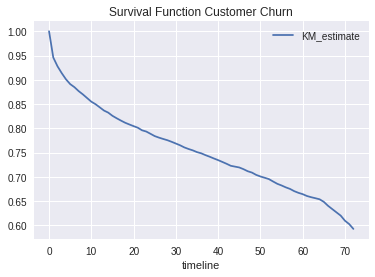

In [58]:
# set data source for KaplanMeier
time = df.tenure.values
event = df.Churn.values

# feed data into KaplanMeier
kmf = lifelines.KaplanMeierFitter()
kmf.fit(time, event_observed=event)
# graph
kmf.survival_function_.plot()
plt.title('Survival Function Customer Churn')

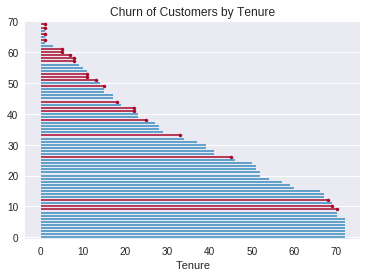

In [57]:
# sampling
sample_churn = df.sample(70,random_state=42)
print(sample_churn.tenure.max())
# set data source for lifelines
time = sample_churn.tenure.values
event = sample_churn.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.grid(axis='x')
ax.set_ylabel("")
ax.set_xlabel("Tenure")
ax.set_title("Churn of Customers by Tenure");
plt.plot();

Text(0.5, 1.0, 'Survival Function Customer Churn')

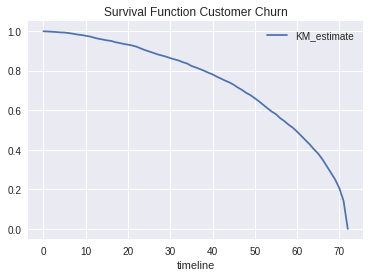

In [59]:
# Churn vs Contract
# set data source for KaplanMeier
time = df.tenure.values
event = df.Contract.values
# feed data into KaplanMeier
kmf = lifelines.KaplanMeierFitter()
kmf.fit(time, event_observed=event)
# graph
kmf.survival_function_.plot()
plt.title('Survival Function Customer Churn')


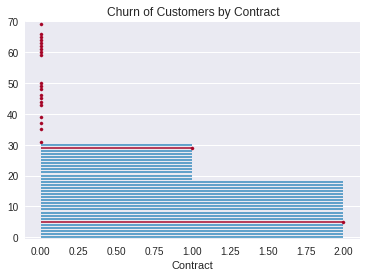

In [51]:
# sampling
sample_churn = df.sample(70,random_state=42)
print(sample_churn.Contract.max())
# set data source for KaplanMeier
time = sample_churn.Contract.values
event = sample_churn.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.grid(axis='x')
ax.set_ylabel("")
ax.set_xlabel("Contract")
ax.set_title("Churn of Customers by Contract");
plt.plot();
# 'Month-to-month':0, 'One year':1, 'Two year':2, 

Text(0.5, 1.0, 'Survival Function Customer Churn')

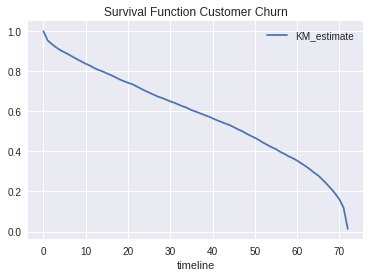

In [60]:
# Churn vs PaymentMethod
# set data source for KaplanMeier
time = df.tenure.values
event = df.PaymentMethod.values
# feed data into KaplanMeier
kmf = lifelines.KaplanMeierFitter()
kmf.fit(time, event_observed=event)
# graph
kmf.survival_function_.plot()
plt.title('Survival Function Customer Churn')



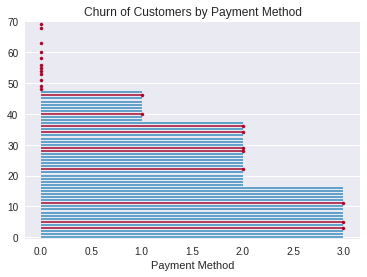

In [53]:
# sampling
sample_churn = df.sample(70,random_state=42)
print(sample_churn.PaymentMethod.max())
# set data source for Lifelines
time = sample_churn.PaymentMethod.values
event = sample_churn.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.grid(axis='x')
ax.set_ylabel("")
ax.set_xlabel("Payment Method")
ax.set_title("Churn of Customers by Payment Method");
plt.plot();
# 'Electronic check':0, 'Mailed check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3

# Resources and stretch goals

Resources:
- [Wikipedia on Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)
- [Wikipedia on Survival functions](https://en.wikipedia.org/wiki/Survival_function)
- [Summary of survival analysis by a biostatistician](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html)
- [Another medical statistics article on survival analysis](https://www.sciencedirect.com/science/article/pii/S1756231716300639)
- [Survival analysis using R lecture slides](http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf)

Stretch goals:
- Make ~5 slides that summarize and deliver your findings, as if you were to present them in a business meeting
- Revisit any of the data from the lecture material, and explore/dig deeper
- Write your own Python functions to calculate a simple hazard or survival function, and try to generate and plot data with them